In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import torch
from datetime import datetime, timezone
import logging
import copy

logging.basicConfig(
    level=logging.INFO,  # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format for the log messages
    handlers=[
        logging.StreamHandler()  # Log to the console
    ]
)

%reload_ext autoreload
%autoreload 2
from core_data_prep.core_data_prep import DataPreparer
from core_data_prep.validations import Validator

from data.raw.retrievers.alpaca_markets_retriever import AlpacaMarketsRetriever
from data.raw.retrievers.stooq_retriever import StooqRetriever
from config.constants import *
from data.processed.dataset_creation import DatasetCreator
from data.processed.indicators import *
from data.processed.targets import Balanced3ClassClassification
from data.processed.normalization import ZScoreOverWindowNormalizer, ZScoreNormalizer, MinMaxNormalizer
from data.processed.dataset_pytorch import DatasetPytorch
from modeling.trainer import Trainer
from modeling.evaluate import evaluate_lgb_regressor, evaluate_torch_regressor, evaluate_torch_regressor_multiasset
from modeling.modeling_utils import print_model_parameters

from modeling.rl.environment import PortfolioEnvironment
from modeling.rl.state import State
from modeling.rl.agent import RlAgent
from modeling.rl.algorithms.policy_gradient import PolicyGradient
from modeling.rl.actors.actor import RlActor
from modeling.rl.actors.signal_predictor_actor import SignalPredictorActor
from modeling.rl.actors.high_energy_low_friction_actor import HighEnergyLowFrictionActor
from modeling.rl.actors.xsmom_actor import XSMomActor
from modeling.rl.actors.tsmom_actor import TSMomActor
from modeling.rl.actors.blsw_actor import BLSWActor
from modeling.rl.actors.allocation_propogation_actor import AllocationPropogationActor
from modeling.rl.actors.market_actor import MarketActor
from modeling.rl.trajectory_dataset import TrajectoryDataset
from modeling.rl.metrics import MetricsCalculator, DEFAULT_METRICS
from modeling.rl.reward import EstimatedReturnReward
from modeling.rl.loss import SumLogReturnLoss, ReinforceLoss
from modeling.rl.visualization.wealth_plot import plot_cumulative_wealth
from modeling.rl.visualization.position_plot import plot_position_heatmap
from config.experiments.cur_experiment import config

torch.backends.cudnn.benchmark = config.train_config.cudnn_benchmark

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
str(config.data_config.frequency)

'1Day'

In [3]:
retriever = config.data_config.retriever
initial_state = config.model_config.model.state_dict()

In [4]:
def evaluate_signal_predictor(end_date: datetime, train_set_last_date: datetime, val_set_last_date: datetime, model=None):
    print(f'Running experiment for {config.data_config.start} to {end_date} with train set last date {train_set_last_date} and val set last date {val_set_last_date}')
    
    retrieval_result = retriever.bars_with_quotes(symbol_or_symbols=config.data_config.symbol_or_symbols, start=config.data_config.start, end=end_date)

    data_preparer = DataPreparer(
        normalizer=config.data_config.normalizer,
        missing_values_handler=config.data_config.missing_values_handler_polars,
        in_seq_len=config.data_config.in_seq_len,
        frequency=str(config.data_config.frequency),
        validator=config.data_config.validator,
    )

    (X_train, y_train, statistics_train), (X_val, y_val, statistics_val), (X_test, y_test, statistics_test) = \
        data_preparer.get_experiment_data(
            data=retrieval_result,
            start_date=None,
            end_date=None,
            features=config.data_config.features_polars,
            statistics=config.data_config.statistics,
            target=config.data_config.target,
            train_set_last_date=train_set_last_date,
            val_set_last_date=val_set_last_date,
        )
    next_return_train, spread_train, volatility_train, \
        next_return_val, spread_val, volatility_val, \
        next_return_test, spread_test, volatility_test = \
            statistics_train['next_return'], statistics_train['spread'], statistics_train['volatility'], \
            statistics_val['next_return'], statistics_val['spread'], statistics_val['volatility'], \
            statistics_test['next_return'], statistics_test['spread'], statistics_test['volatility']
        
    print(X_train.shape, y_train.shape, next_return_train.shape, spread_train.shape, volatility_train.shape, X_test.shape,\
         y_test.shape, next_return_test.shape, spread_test.shape, volatility_test.shape)

    if not model: 
        print('Training model...')
        train_loader = DatasetPytorch(X_train, y_train, learning_task='regression').as_dataloader(
            batch_size=config.train_config.batch_size,
            shuffle=config.train_config.shuffle,
            num_workers=config.train_config.num_workers,
            prefetch_factor=config.train_config.prefetch_factor,
            pin_memory=config.train_config.pin_memory,
            persistent_workers=config.train_config.persistent_workers,
            drop_last=config.train_config.drop_last
        )
        val_loader = DatasetPytorch(X_val, y_val, learning_task='regression').as_dataloader(
            batch_size=config.train_config.batch_size,
            shuffle=config.train_config.shuffle,
            num_workers=config.train_config.num_workers,
            prefetch_factor=config.train_config.prefetch_factor,
            pin_memory=config.train_config.pin_memory,
            persistent_workers=config.train_config.persistent_workers,
            drop_last=config.train_config.drop_last
        )

        model = config.model_config.model
        model.load_state_dict(initial_state)

        trainer = Trainer(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            loss_fn=config.train_config.loss_fn,
            optimizer=config.train_config.optimizer,
            scheduler=config.train_config.scheduler,
            num_epochs=config.train_config.num_epochs,
            early_stopping_patience=config.train_config.early_stopping_patience,
            device=config.train_config.device,
            metrics=config.train_config.metrics,
            save_path=config.train_config.save_path
        )

        model, history = trainer.train()
    else: 
        print('Using existing model...')

    test_trajectory_loader = TrajectoryDataset(X_test, next_return_test, spread_test, volatility_test, \
            trajectory_length=config.rl_config.trajectory_length, horizon=config.data_config.horizon).as_dataloader(
        batch_size=1, 
        shuffle=False,
        num_workers=8,
        prefetch_factor=4,
        pin_memory=True,
        persistent_workers=True,
        drop_last=False,
    )

    env = PortfolioEnvironment(
        reward_function=EstimatedReturnReward(fee=config.rl_config.fee, spread_multiplier=config.rl_config.spread_multiplier),
    )

    actor = RlActor(
        copy.deepcopy(model), 
        n_assets=len(config.data_config.symbol_or_symbols),
        train_signal_predictor=False, 
    ).to(device)

    # signal_predictor_actor = SignalPredictorActor(
    #     copy.deepcopy(model), 
    #     trade_asset_count=config.rl_config.trade_asset_count,
    #     train_signal_predictor=False
    # ).to(device)

    eval_actor = AllocationPropogationActor(
        copy.deepcopy(model), 
        train_allocator=False
    ).to(device)

    rl_agent = RlAgent(
        actor, 
        env
    )

    metrics_calculator = MetricsCalculator(
        metrics=DEFAULT_METRICS
    )

    policy_gradient = PolicyGradient(
        rl_agent, 
        None, 
        test_trajectory_loader, 
        metrics_calculator=metrics_calculator,
        optimizer=torch.optim.AdamW(
            [p for p in actor.parameters() if p.requires_grad], 
            lr=1e-3,
            weight_decay=1e-5,
            amsgrad=True),
        scheduler=None,
        loss_fn=ReinforceLoss(use_baseline=False),
        num_epochs=10,
        device=device
    )

    epoch_loss, realized_returns_signal_predictor, actions_signal_predictor = policy_gradient.evaluate(eval_actor, test_trajectory_loader)
    return realized_returns_signal_predictor, model, min(history['val_loss'])


In [5]:
# start_end_last_train_dates = [
#     {'end': datetime(2011, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2010, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2008, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2012, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2011, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2009, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2013, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2012, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2010, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2014, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2013, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2011, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2015, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2014, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2012, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2016, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2015, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2013, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2017, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2016, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2014, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2018, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2017, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2015, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2019, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2018, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2016, 1, 1, tzinfo=timezone.utc)},
# ]
# start_end_last_train_dates = [
#     {'end': datetime(2010, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2009, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2008, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2011, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2010, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2009, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2012, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2011, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2010, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2013, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2012, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2011, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2014, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2013, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2012, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2015, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2014, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2013, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2016, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2015, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2014, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2017, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2016, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2015, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2018, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2017, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2016, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2019, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2018, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2017, 1, 1, tzinfo=timezone.utc)},
# ]
# start_end_last_train_dates = [
#     {'end': datetime(2001, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2000, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(1999, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2002, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2001, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2000, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2004, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2002, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2000, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2006, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2004, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2002, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2008, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2006, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2004, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2010, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2008, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2006, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2012, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2010, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2008, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2014, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2012, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2010, 1, 1, tzinfo=timezone.utc)},
#     {'end': datetime(2019, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2014, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2012, 1, 1, tzinfo=timezone.utc)},
# ]
start_end_last_train_dates = [
    {'end': datetime(2000, 7, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2000, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(1999, 7, 1, tzinfo=timezone.utc)},
    {'end': datetime(2001, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2000, 7, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2000, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2001, 7, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2001, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2000, 7, 1, tzinfo=timezone.utc)},
    {'end': datetime(2002, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2001, 7, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2001, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2002, 7, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2002, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2001, 7, 1, tzinfo=timezone.utc)},
    {'end': datetime(2003, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2002, 7, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2002, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2004, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2003, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2002, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2008, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2004, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2002, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2014, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2008, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2006, 1, 1, tzinfo=timezone.utc)},
    {'end': datetime(2019, 1, 1, tzinfo=timezone.utc), 'last_val_date': datetime(2014, 1, 1, tzinfo=timezone.utc), 'last_train_date': datetime(2012, 1, 1, tzinfo=timezone.utc)},
]

In [6]:
realized_returns = []
for i in range(len(start_end_last_train_dates)):
    best_model = None
    best_loss = 100.
    episode_returns = None
    for j in range(1): 
        cur_returns, cur_model, cur_val_loss = evaluate_signal_predictor(
            start_end_last_train_dates[i]['end'], 
            start_end_last_train_dates[i]['last_train_date'], 
            start_end_last_train_dates[i]['last_val_date'], 
            best_model)
        if cur_val_loss < best_loss: 
            logging.info('Found better val loss, updating episode_returns')
            best_loss = cur_val_loss
            episode_returns = cur_returns
    logging.info(f'Len of episode_returns: {len(episode_returns)}')
    realized_returns.extend(episode_returns)
    
    # for j in range(1): 
    #     cur_rezlized_returns, model = evaluate_signal_predictor(
    #         start_end_last_train_dates[i]['start'], 
    #         start_end_last_train_dates[i]['last_val_date'], 
    #         start_end_last_train_dates[i]['last_train_date'])
    #     if np.mean(cur_rezlized_returns) > best_mean_return:
    #         best_mean_return = np.mean(cur_rezlized_returns)
    #         best_model = model

    # realized_returns.extend(
    #     evaluate_signal_predictor(
    #         start_end_last_train_dates[i]['end'], 
    #         start_end_last_train_dates[i]['last_train_date'], 
    #         start_end_last_train_dates[i]['last_val_date'], 
    #         best_model)[0])

Running experiment for 1970-01-02 00:00:00-05:00 to 2000-07-01 00:00:00+00:00 with train set last date 1999-07-01 00:00:00+00:00 and val set last date 2000-01-01 00:00:00+00:00


2025-11-25 17:26:41,187 - WARNING - No data found for v_us_d.csv between 1970-01-02 00:00:00-05:00 and 2000-07-01 00:00:00+00:00
2025-11-25 17:26:41,374 - WARNING - No data found for trv_us_d.csv between 1970-01-02 00:00:00-05:00 and 2000-07-01 00:00:00+00:00
2025-11-25 17:26:44,441 - WARNING - No data found for crm_us_d.csv between 1970-01-02 00:00:00-05:00 and 2000-07-01 00:00:00+00:00
2025-11-25 17:26:45,409 - INFO - Using monolithic slices with -60 timestamps
2025-11-25 17:26:46,083 - INFO - Found 6823 train slices, 211 val slices, 207 test slices
2025-11-25 17:26:46,084 - INFO - Trained per-asset targets


(10653, 27, 60, 16) (10653, 27) (10653, 27) (10653, 27) (10653, 27) (183, 27, 60, 16) (183, 27) (183, 27) (183, 27) (183, 27)
Training model...


2025-11-25 17:27:06,868 - INFO - Model compiled with torch.compile()
2025-11-25 17:27:06,869 - INFO - Epoch 1/20
2025-11-25 17:27:11,721 - INFO - Train Loss: -0.0107     
2025-11-25 17:27:11,722 - INFO - Train Log_return: -0.0156
2025-11-25 17:27:11,723 - INFO - Train Mean_return: 0.0169
2025-11-25 17:27:11,724 - INFO - Val   Loss: -0.0329
2025-11-25 17:27:11,725 - INFO - Val   Log_return: -0.0449
2025-11-25 17:27:11,726 - INFO - Val   Mean_return: 0.0488
2025-11-25 17:27:11,726 - INFO - New best model found! Updating best state dict.
2025-11-25 17:27:11,729 - INFO - 
2025-11-25 17:27:11,730 - INFO - Epoch 2/20
2025-11-25 17:27:14,231 - INFO - Train Loss: -0.0134     
2025-11-25 17:27:14,232 - INFO - Train Log_return: -0.0210
2025-11-25 17:27:14,232 - INFO - Train Mean_return: 0.0230
2025-11-25 17:27:14,233 - INFO - Val   Loss: -0.0246
2025-11-25 17:27:14,233 - INFO - Val   Log_return: -0.0361
2025-11-25 17:27:14,234 - INFO - Val   Mean_return: 0.0395
2025-11-25 17:27:14,234 - INFO - 


[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


2025-11-25 17:27:35,018 - INFO - Found better val loss, updating episode_returns
2025-11-25 17:27:35,019 - INFO - Len of episode_returns: 7


Running experiment for 1970-01-02 00:00:00-05:00 to 2001-01-01 00:00:00+00:00 with train set last date 2000-01-01 00:00:00+00:00 and val set last date 2000-07-01 00:00:00+00:00


2025-11-25 17:27:35,382 - WARNING - No data found for v_us_d.csv between 1970-01-02 00:00:00-05:00 and 2001-01-01 00:00:00+00:00
2025-11-25 17:27:35,526 - WARNING - No data found for trv_us_d.csv between 1970-01-02 00:00:00-05:00 and 2001-01-01 00:00:00+00:00
2025-11-25 17:27:38,247 - WARNING - No data found for crm_us_d.csv between 1970-01-02 00:00:00-05:00 and 2001-01-01 00:00:00+00:00
2025-11-25 17:27:39,122 - INFO - Using monolithic slices with -60 timestamps
2025-11-25 17:27:39,741 - INFO - Found 6950 train slices, 207 val slices, 210 test slices
2025-11-25 17:27:39,742 - INFO - Trained per-asset targets


(10837, 27, 60, 16) (10837, 27) (10837, 27) (10837, 27) (10837, 27) (183, 27, 60, 16) (183, 27) (183, 27) (183, 27) (183, 27)
Training model...


2025-11-25 17:27:56,205 - INFO - Model compiled with torch.compile()
2025-11-25 17:27:56,206 - INFO - Epoch 1/20
2025-11-25 17:27:58,473 - INFO - Train Loss: -0.0096     
2025-11-25 17:27:58,474 - INFO - Train Log_return: -0.0133
2025-11-25 17:27:58,475 - INFO - Train Mean_return: 0.0143
2025-11-25 17:27:58,476 - INFO - Val   Loss: -0.0123
2025-11-25 17:27:58,477 - INFO - Val   Log_return: -0.0195
2025-11-25 17:27:58,477 - INFO - Val   Mean_return: 0.0214
2025-11-25 17:27:58,478 - INFO - New best model found! Updating best state dict.
2025-11-25 17:27:58,481 - INFO - 
2025-11-25 17:27:58,482 - INFO - Epoch 2/20
2025-11-25 17:28:00,444 - INFO - Train Loss: -0.0123     
2025-11-25 17:28:00,445 - INFO - Train Log_return: -0.0189
2025-11-25 17:28:00,446 - INFO - Train Mean_return: 0.0206
2025-11-25 17:28:00,446 - INFO - Val   Loss: -0.0139
2025-11-25 17:28:00,447 - INFO - Val   Log_return: -0.0208
2025-11-25 17:28:00,447 - INFO - Val   Mean_return: 0.0227
2025-11-25 17:28:00,448 - INFO - N

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


2025-11-25 17:28:17,920 - INFO - Found better val loss, updating episode_returns
2025-11-25 17:28:17,921 - INFO - Len of episode_returns: 7


Running experiment for 1970-01-02 00:00:00-05:00 to 2001-07-01 00:00:00+00:00 with train set last date 2000-07-01 00:00:00+00:00 and val set last date 2001-01-01 00:00:00+00:00


2025-11-25 17:28:18,275 - WARNING - No data found for v_us_d.csv between 1970-01-02 00:00:00-05:00 and 2001-07-01 00:00:00+00:00
2025-11-25 17:28:18,434 - WARNING - No data found for trv_us_d.csv between 1970-01-02 00:00:00-05:00 and 2001-07-01 00:00:00+00:00
2025-11-25 17:28:21,220 - WARNING - No data found for crm_us_d.csv between 1970-01-02 00:00:00-05:00 and 2001-07-01 00:00:00+00:00
2025-11-25 17:28:22,162 - INFO - Using monolithic slices with -60 timestamps
2025-11-25 17:28:22,810 - INFO - Found 7075 train slices, 210 val slices, 207 test slices
2025-11-25 17:28:22,812 - INFO - Trained per-asset targets


(11019, 27, 60, 16) (11019, 27) (11019, 27) (11019, 27) (11019, 27) (179, 27, 60, 16) (179, 27) (179, 27) (179, 27) (179, 27)
Training model...


2025-11-25 17:28:39,568 - INFO - Model compiled with torch.compile()
2025-11-25 17:28:39,568 - INFO - Epoch 1/20
2025-11-25 17:28:41,884 - INFO - Train Loss: -0.0093     
2025-11-25 17:28:41,885 - INFO - Train Log_return: -0.0129
2025-11-25 17:28:41,885 - INFO - Train Mean_return: 0.0139
2025-11-25 17:28:41,886 - INFO - Val   Loss: 0.0080
2025-11-25 17:28:41,887 - INFO - Val   Log_return: 0.0050
2025-11-25 17:28:41,887 - INFO - Val   Mean_return: -0.0042
2025-11-25 17:28:41,888 - INFO - New best model found! Updating best state dict.
2025-11-25 17:28:41,891 - INFO - 
2025-11-25 17:28:41,892 - INFO - Epoch 2/20
2025-11-25 17:28:43,669 - INFO - Train Loss: -0.0124     
2025-11-25 17:28:43,670 - INFO - Train Log_return: -0.0188
2025-11-25 17:28:43,670 - INFO - Train Mean_return: 0.0205
2025-11-25 17:28:43,671 - INFO - Val   Loss: 0.0093
2025-11-25 17:28:43,671 - INFO - Val   Log_return: 0.0064
2025-11-25 17:28:43,672 - INFO - Val   Mean_return: -0.0056
2025-11-25 17:28:43,673 - INFO - 
20

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


2025-11-25 17:28:54,868 - INFO - Found better val loss, updating episode_returns
2025-11-25 17:28:54,869 - INFO - Len of episode_returns: 6


Running experiment for 1970-01-02 00:00:00-05:00 to 2002-01-01 00:00:00+00:00 with train set last date 2001-01-01 00:00:00+00:00 and val set last date 2001-07-01 00:00:00+00:00


2025-11-25 17:28:55,205 - WARNING - No data found for v_us_d.csv between 1970-01-02 00:00:00-05:00 and 2002-01-01 00:00:00+00:00
2025-11-25 17:28:55,342 - WARNING - No data found for trv_us_d.csv between 1970-01-02 00:00:00-05:00 and 2002-01-01 00:00:00+00:00
2025-11-25 17:28:58,104 - WARNING - No data found for crm_us_d.csv between 1970-01-02 00:00:00-05:00 and 2002-01-01 00:00:00+00:00
2025-11-25 17:28:59,016 - INFO - Using monolithic slices with -60 timestamps
2025-11-25 17:28:59,663 - INFO - Found 7201 train slices, 207 val slices, 206 test slices
2025-11-25 17:28:59,664 - INFO - Trained per-asset targets


(11201, 27, 60, 16) (11201, 27) (11201, 27) (11201, 27) (11201, 27) (183, 27, 60, 16) (183, 27) (183, 27) (183, 27) (183, 27)
Training model...


2025-11-25 17:29:17,280 - INFO - Model compiled with torch.compile()
2025-11-25 17:29:17,280 - INFO - Epoch 1/20
2025-11-25 17:29:19,414 - INFO - Train Loss: -0.0091     
2025-11-25 17:29:19,415 - INFO - Train Log_return: -0.0127
2025-11-25 17:29:19,415 - INFO - Train Mean_return: 0.0137
2025-11-25 17:29:19,416 - INFO - Val   Loss: -0.0023
2025-11-25 17:29:19,416 - INFO - Val   Log_return: -0.0108
2025-11-25 17:29:19,417 - INFO - Val   Mean_return: 0.0129
2025-11-25 17:29:19,417 - INFO - New best model found! Updating best state dict.
2025-11-25 17:29:19,419 - INFO - 
2025-11-25 17:29:19,419 - INFO - Epoch 2/20
2025-11-25 17:29:21,289 - INFO - Train Loss: -0.0129     
2025-11-25 17:29:21,289 - INFO - Train Log_return: -0.0203
2025-11-25 17:29:21,290 - INFO - Train Mean_return: 0.0223
2025-11-25 17:29:21,290 - INFO - Val   Loss: -0.0187
2025-11-25 17:29:21,290 - INFO - Val   Log_return: -0.0306
2025-11-25 17:29:21,291 - INFO - Val   Mean_return: 0.0338
2025-11-25 17:29:21,292 - INFO - N

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


2025-11-25 17:29:35,818 - INFO - Found better val loss, updating episode_returns
2025-11-25 17:29:35,819 - INFO - Len of episode_returns: 7


Running experiment for 1970-01-02 00:00:00-05:00 to 2002-07-01 00:00:00+00:00 with train set last date 2001-07-01 00:00:00+00:00 and val set last date 2002-01-01 00:00:00+00:00


2025-11-25 17:29:36,095 - WARNING - No data found for v_us_d.csv between 1970-01-02 00:00:00-05:00 and 2002-07-01 00:00:00+00:00
2025-11-25 17:29:36,235 - WARNING - No data found for trv_us_d.csv between 1970-01-02 00:00:00-05:00 and 2002-07-01 00:00:00+00:00
2025-11-25 17:29:38,764 - WARNING - No data found for crm_us_d.csv between 1970-01-02 00:00:00-05:00 and 2002-07-01 00:00:00+00:00
2025-11-25 17:29:39,609 - INFO - Using monolithic slices with -60 timestamps
2025-11-25 17:29:40,212 - INFO - Found 7326 train slices, 206 val slices, 203 test slices
2025-11-25 17:29:40,213 - INFO - Trained per-asset targets


(11383, 27, 60, 16) (11383, 27) (11383, 27) (11383, 27) (11383, 27) (179, 27, 60, 16) (179, 27) (179, 27) (179, 27) (179, 27)
Training model...


2025-11-25 17:29:53,903 - INFO - Model compiled with torch.compile()
2025-11-25 17:29:53,904 - INFO - Epoch 1/20
2025-11-25 17:29:56,413 - INFO - Train Loss: -0.0090     
2025-11-25 17:29:56,414 - INFO - Train Log_return: -0.0128
2025-11-25 17:29:56,415 - INFO - Train Mean_return: 0.0139
2025-11-25 17:29:56,415 - INFO - Val   Loss: 0.0005
2025-11-25 17:29:56,416 - INFO - Val   Log_return: -0.0147
2025-11-25 17:29:56,417 - INFO - Val   Mean_return: 0.0186
2025-11-25 17:29:56,418 - INFO - New best model found! Updating best state dict.
2025-11-25 17:29:56,420 - INFO - 
2025-11-25 17:29:56,421 - INFO - Epoch 2/20
2025-11-25 17:29:58,084 - INFO - Train Loss: -0.0131     
2025-11-25 17:29:58,085 - INFO - Train Log_return: -0.0205
2025-11-25 17:29:58,086 - INFO - Train Mean_return: 0.0225
2025-11-25 17:29:58,086 - INFO - Val   Loss: 0.0018
2025-11-25 17:29:58,086 - INFO - Val   Log_return: -0.0129
2025-11-25 17:29:58,087 - INFO - Val   Mean_return: 0.0167
2025-11-25 17:29:58,087 - INFO - 
20

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


2025-11-25 17:30:19,301 - INFO - Found better val loss, updating episode_returns
2025-11-25 17:30:19,302 - INFO - Len of episode_returns: 6


Running experiment for 1970-01-02 00:00:00-05:00 to 2003-01-01 00:00:00+00:00 with train set last date 2002-01-01 00:00:00+00:00 and val set last date 2002-07-01 00:00:00+00:00


2025-11-25 17:30:19,614 - WARNING - No data found for v_us_d.csv between 1970-01-02 00:00:00-05:00 and 2003-01-01 00:00:00+00:00
2025-11-25 17:30:19,755 - WARNING - No data found for trv_us_d.csv between 1970-01-02 00:00:00-05:00 and 2003-01-01 00:00:00+00:00
2025-11-25 17:30:22,365 - WARNING - No data found for crm_us_d.csv between 1970-01-02 00:00:00-05:00 and 2003-01-01 00:00:00+00:00
2025-11-25 17:30:23,258 - INFO - Using monolithic slices with -60 timestamps
2025-11-25 17:30:23,915 - INFO - Found 7449 train slices, 203 val slices, 211 test slices
2025-11-25 17:30:23,916 - INFO - Trained per-asset targets


(11568, 27, 60, 16) (11568, 27) (11568, 27) (11568, 27) (11568, 27) (184, 27, 60, 16) (184, 27) (184, 27) (184, 27) (184, 27)
Training model...


2025-11-25 17:30:37,360 - INFO - Model compiled with torch.compile()
2025-11-25 17:30:37,361 - INFO - Epoch 1/20
2025-11-25 17:30:39,780 - INFO - Train Loss: -0.0086     
2025-11-25 17:30:39,781 - INFO - Train Log_return: -0.0122
2025-11-25 17:30:39,782 - INFO - Train Mean_return: 0.0132
2025-11-25 17:30:39,783 - INFO - Val   Loss: 0.0181
2025-11-25 17:30:39,784 - INFO - Val   Log_return: 0.0144
2025-11-25 17:30:39,785 - INFO - Val   Mean_return: -0.0134
2025-11-25 17:30:39,785 - INFO - New best model found! Updating best state dict.
2025-11-25 17:30:39,790 - INFO - 
2025-11-25 17:30:39,792 - INFO - Epoch 2/20
2025-11-25 17:30:41,795 - INFO - Train Loss: -0.0118     
2025-11-25 17:30:41,796 - INFO - Train Log_return: -0.0181
2025-11-25 17:30:41,797 - INFO - Train Mean_return: 0.0198
2025-11-25 17:30:41,797 - INFO - Val   Loss: 0.0212
2025-11-25 17:30:41,798 - INFO - Val   Log_return: 0.0175
2025-11-25 17:30:41,799 - INFO - Val   Mean_return: -0.0164
2025-11-25 17:30:41,800 - INFO - 
20

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


2025-11-25 17:31:02,989 - INFO - Found better val loss, updating episode_returns
2025-11-25 17:31:02,990 - INFO - Len of episode_returns: 7


Running experiment for 1970-01-02 00:00:00-05:00 to 2004-01-01 00:00:00+00:00 with train set last date 2002-01-01 00:00:00+00:00 and val set last date 2003-01-01 00:00:00+00:00


2025-11-25 17:31:03,292 - WARNING - No data found for v_us_d.csv between 1970-01-02 00:00:00-05:00 and 2004-01-01 00:00:00+00:00
2025-11-25 17:31:03,409 - WARNING - No data found for trv_us_d.csv between 1970-01-02 00:00:00-05:00 and 2004-01-01 00:00:00+00:00
2025-11-25 17:31:05,901 - WARNING - No data found for crm_us_d.csv between 1970-01-02 00:00:00-05:00 and 2004-01-01 00:00:00+00:00
2025-11-25 17:31:06,722 - INFO - Using monolithic slices with -60 timestamps
2025-11-25 17:31:07,349 - INFO - Found 7449 train slices, 331 val slices, 336 test slices
2025-11-25 17:31:07,350 - INFO - Trained per-asset targets


(11568, 27, 60, 16) (11568, 27) (11568, 27) (11568, 27) (11568, 27) (366, 27, 60, 16) (366, 27) (366, 27) (366, 27) (366, 27)
Training model...


2025-11-25 17:31:28,296 - INFO - Model compiled with torch.compile()
2025-11-25 17:31:28,296 - INFO - Epoch 1/20
2025-11-25 17:31:30,763 - INFO - Train Loss: -0.0084     
2025-11-25 17:31:30,765 - INFO - Train Log_return: -0.0120
2025-11-25 17:31:30,766 - INFO - Train Mean_return: 0.0130
2025-11-25 17:31:30,768 - INFO - Val   Loss: 0.0275
2025-11-25 17:31:30,769 - INFO - Val   Log_return: 0.0174
2025-11-25 17:31:30,770 - INFO - Val   Mean_return: -0.0146
2025-11-25 17:31:30,771 - INFO - New best model found! Updating best state dict.
2025-11-25 17:31:30,776 - INFO - 
2025-11-25 17:31:30,777 - INFO - Epoch 2/20
2025-11-25 17:31:32,800 - INFO - Train Loss: -0.0120     
2025-11-25 17:31:32,801 - INFO - Train Log_return: -0.0187
2025-11-25 17:31:32,801 - INFO - Train Mean_return: 0.0206
2025-11-25 17:31:32,802 - INFO - Val   Loss: 0.0385
2025-11-25 17:31:32,802 - INFO - Val   Log_return: 0.0248
2025-11-25 17:31:32,803 - INFO - Val   Mean_return: -0.0210
2025-11-25 17:31:32,803 - INFO - 
20

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


2025-11-25 17:31:46,683 - INFO - Found better val loss, updating episode_returns
2025-11-25 17:31:46,684 - INFO - Len of episode_returns: 13


Running experiment for 1970-01-02 00:00:00-05:00 to 2008-01-01 00:00:00+00:00 with train set last date 2002-01-01 00:00:00+00:00 and val set last date 2004-01-01 00:00:00+00:00


2025-11-25 17:31:46,977 - WARNING - No data found for v_us_d.csv between 1970-01-02 00:00:00-05:00 and 2008-01-01 00:00:00+00:00
2025-11-25 17:31:50,500 - INFO - Using monolithic slices with -60 timestamps
2025-11-25 17:31:51,237 - INFO - Found 7449 train slices, 583 val slices, 1090 test slices
2025-11-25 17:31:51,238 - INFO - Trained per-asset targets


(11568, 29, 60, 16) (11568, 29) (11568, 29) (11568, 29) (11568, 29) (1462, 29, 60, 16) (1462, 29) (1462, 29) (1462, 29) (1462, 29)
Training model...


2025-11-25 17:32:15,863 - INFO - Model compiled with torch.compile()
2025-11-25 17:32:15,864 - INFO - Epoch 1/20
2025-11-25 17:32:20,259 - INFO - Train Loss: -0.0078     
2025-11-25 17:32:20,260 - INFO - Train Log_return: -0.0111
2025-11-25 17:32:20,260 - INFO - Train Mean_return: 0.0119
2025-11-25 17:32:20,261 - INFO - Val   Loss: 0.0027
2025-11-25 17:32:20,262 - INFO - Val   Log_return: -0.0036
2025-11-25 17:32:20,262 - INFO - Val   Mean_return: 0.0051
2025-11-25 17:32:20,264 - INFO - New best model found! Updating best state dict.
2025-11-25 17:32:20,265 - INFO - 
2025-11-25 17:32:20,266 - INFO - Epoch 2/20
2025-11-25 17:32:22,932 - INFO - Train Loss: -0.0111     
2025-11-25 17:32:22,932 - INFO - Train Log_return: -0.0182
2025-11-25 17:32:22,933 - INFO - Train Mean_return: 0.0202
2025-11-25 17:32:22,933 - INFO - Val   Loss: 0.0044
2025-11-25 17:32:22,934 - INFO - Val   Log_return: -0.0114
2025-11-25 17:32:22,935 - INFO - Val   Mean_return: 0.0154
2025-11-25 17:32:22,935 - INFO - 
20

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


2025-11-25 17:32:39,104 - INFO - Found better val loss, updating episode_returns
2025-11-25 17:32:39,105 - INFO - Len of episode_returns: 49


Running experiment for 1970-01-02 00:00:00-05:00 to 2014-01-01 00:00:00+00:00 with train set last date 2006-01-01 00:00:00+00:00 and val set last date 2008-01-01 00:00:00+00:00


2025-11-25 17:32:42,560 - INFO - Using monolithic slices with -60 timestamps
2025-11-25 17:32:43,367 - INFO - Found 8457 train slices, 584 val slices, 1594 test slices
2025-11-25 17:32:43,368 - INFO - Trained per-asset targets


(13028, 30, 60, 16) (13028, 30) (13028, 30) (13028, 30) (13028, 30) (2192, 30, 60, 16) (2192, 30) (2192, 30) (2192, 30) (2192, 30)
Training model...


2025-11-25 17:33:08,653 - INFO - Model compiled with torch.compile()
2025-11-25 17:33:08,654 - INFO - Epoch 1/20
2025-11-25 17:33:12,477 - INFO - Train Loss: -0.0071       
2025-11-25 17:33:12,479 - INFO - Train Log_return: -0.0103
2025-11-25 17:33:12,479 - INFO - Train Mean_return: 0.0112
2025-11-25 17:33:12,480 - INFO - Val   Loss: -0.0101
2025-11-25 17:33:12,481 - INFO - Val   Log_return: -0.0121
2025-11-25 17:33:12,482 - INFO - Val   Mean_return: 0.0127
2025-11-25 17:33:12,483 - INFO - New best model found! Updating best state dict.
2025-11-25 17:33:12,485 - INFO - 
2025-11-25 17:33:12,485 - INFO - Epoch 2/20
2025-11-25 17:33:14,885 - INFO - Train Loss: -0.0106      
2025-11-25 17:33:14,886 - INFO - Train Log_return: -0.0178
2025-11-25 17:33:14,887 - INFO - Train Mean_return: 0.0197
2025-11-25 17:33:14,887 - INFO - Val   Loss: -0.0100
2025-11-25 17:33:14,889 - INFO - Val   Log_return: -0.0131
2025-11-25 17:33:14,889 - INFO - Val   Mean_return: 0.0139
2025-11-25 17:33:14,890 - INFO 

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


2025-11-25 17:33:32,054 - INFO - Found better val loss, updating episode_returns
2025-11-25 17:33:32,055 - INFO - Len of episode_returns: 74


Running experiment for 1970-01-02 00:00:00-05:00 to 2019-01-01 00:00:00+00:00 with train set last date 2012-01-01 00:00:00+00:00 and val set last date 2014-01-01 00:00:00+00:00


2025-11-25 17:33:35,621 - INFO - Using monolithic slices with -60 timestamps
2025-11-25 17:33:36,540 - INFO - Found 9968 train slices, 584 val slices, 1342 test slices
2025-11-25 17:33:36,541 - INFO - Trained per-asset targets


(15219, 30, 60, 16) (15219, 30) (15219, 30) (15219, 30) (15219, 30) (1827, 30, 60, 16) (1827, 30) (1827, 30) (1827, 30) (1827, 30)
Training model...


2025-11-25 17:34:05,561 - INFO - Model compiled with torch.compile()
2025-11-25 17:34:05,562 - INFO - Epoch 1/20
2025-11-25 17:34:08,996 - INFO - Train Loss: -0.0062       
2025-11-25 17:34:08,997 - INFO - Train Log_return: -0.0097
2025-11-25 17:34:08,998 - INFO - Train Mean_return: 0.0107
2025-11-25 17:34:08,998 - INFO - Val   Loss: -0.0155
2025-11-25 17:34:08,999 - INFO - Val   Log_return: -0.0169
2025-11-25 17:34:09,000 - INFO - Val   Mean_return: 0.0174
2025-11-25 17:34:09,000 - INFO - New best model found! Updating best state dict.
2025-11-25 17:34:09,004 - INFO - 
2025-11-25 17:34:09,004 - INFO - Epoch 2/20
2025-11-25 17:34:11,808 - INFO - Train Loss: -0.0087       
2025-11-25 17:34:11,808 - INFO - Train Log_return: -0.0154
2025-11-25 17:34:11,809 - INFO - Train Mean_return: 0.0172
2025-11-25 17:34:11,809 - INFO - Val   Loss: -0.0153
2025-11-25 17:34:11,810 - INFO - Val   Log_return: -0.0169
2025-11-25 17:34:11,810 - INFO - Val   Mean_return: 0.0175
2025-11-25 17:34:11,810 - INFO

[PolicyGradient] [VAL] Epoch 0/10 — Loss: 0.0000


2025-11-25 17:34:37,030 - INFO - Found better val loss, updating episode_returns
2025-11-25 17:34:37,031 - INFO - Len of episode_returns: 61


In [7]:
len(realized_returns)

237

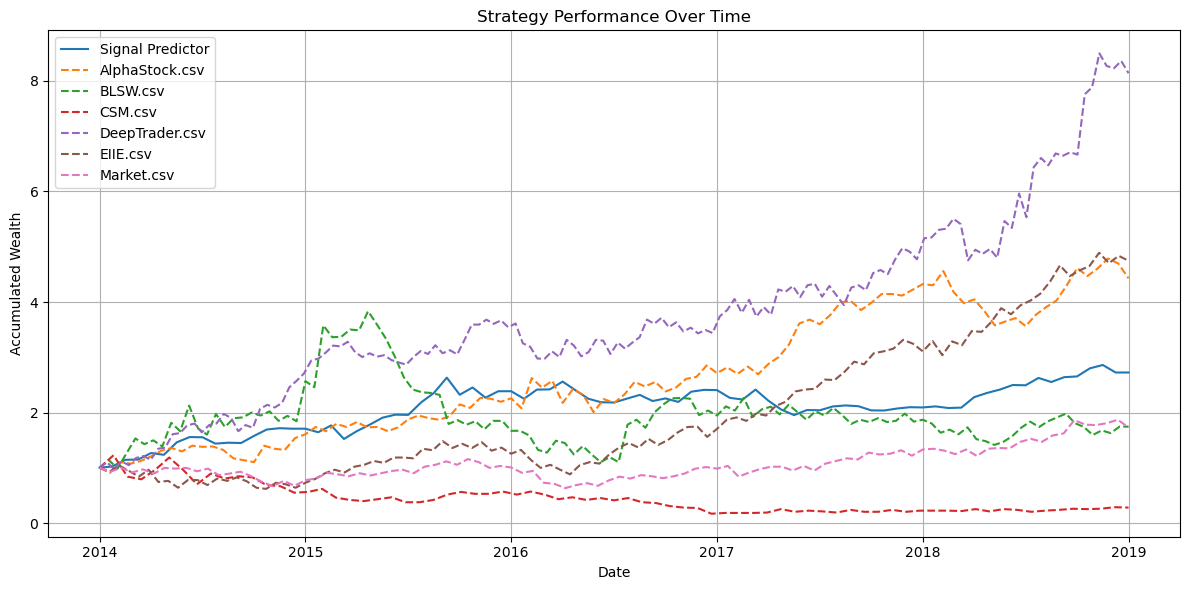

In [9]:
plot_cumulative_wealth(
    returns_dict={
        'Signal Predictor': realized_returns,
    }, 
    start_time=config.data_config.val_set_last_date, 
    end_time=config.data_config.end,
    compare_to_baseline=True
)

In [9]:
pd.Series(realized_returns).to_csv('realized_returns_ours.csv')